In [ ]:
!pip install yfinance

In [2]:
import yfinance as yf
import datetime as dt
import math
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

from bs4 import BeautifulSoup

In [4]:
# tickers for companies
stockCodes = ['SASA.IS', 'EREGL.IS', 'XU100.IS']

# start and end dates for financial data (last ~5 years)
startDate = dt.datetime(2017, 11, 17)
endDate = dt.datetime(2022, 11, 23)

# split ratio for training and testing datasets
splitRatio = 0.8

# number of past days the model will take into account while training
n_pasts = [60, 30, 7]

# number of experiments
n_run = 5

# number of epochs with no improvement after which training will be stopped (for early stopping)
n_patience = 8

# batch size for training
batchSize = 16

# number of epoch for training
n_epoch = 50

# list of results
res = []

In [5]:
# loop for trying different stock codes
for i in range(len(stockCodes)):
    print('\n\n\033[31;1;4mDATA PREPROCESSING\033[0m')
    print('\x1b[31mStock Code: {}\x1b[0m'.format(stockCodes[i]))
    
    #################### DATA COLLECTION ####################
    # getting financial data between start and end dates from Yahoo Finance using yfinance API
    data = yf.download(stockCodes[i], start = startDate, end = endDate)

    # 2020-07-24 removing 2 decimal digits in BIST100
    if stockCodes[i] == 'XU100.IS':
        data2 = data.loc[:'2020-07-24']
        data3 = data2[['Open', 'High', 'Low', 'Close', 'Adj Close']] / 100
        data3['Volume'] = data2['Volume']
        data4 = data3.append(data.loc['2020-07-25':])
        del data
        data = data4.copy()

    # columns: High, Low, Open, Close, Volume, Adj Close
    print('Shape of data: {}'.format(data.shape))

    # let's check it
    print(data)

    # plotting line charts for all features
    df_plot = data.copy()
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, figsize = (14, 7))
    for id, ax in enumerate(fig.axes):
        sb.lineplot(data = df_plot.iloc[:, id], ax = ax)
        ax.tick_params(axis = 'x', rotation = 30, labelsize = 10, length = 0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

    # plotting line chart for 'Close'
    years = mdates.YearLocator() 
    fig, ax1 = plt.subplots(figsize = (16, 6))
    ax1.xaxis.set_major_locator(years)
    ax1.legend([stockCodes[i]], fontsize = 12)
    plt.title(stockCodes[i] + ' from ' + str(startDate.date()) + ' to ' + str(endDate.date()))
    sb.lineplot(data = data['Close'], label = stockCodes[i], linewidth = 1.0)
    plt.ylabel('Close Price')
    plt.show()
    #########################################################

    #################### DATA PREPROCESSING (DATA CLEANING & FEATURE ENGINEERING) ####################
    
    # processing bull/bear questionnaire data
    with open('/content/drive/MyDrive/StockPricePrediction/data_sentiment_{}.html'.format(stockCodes[i]), 'r') as f:
        contents = f.read()
        soup = BeautifulSoup(contents, 'lxml')

        table = soup.find('table', attrs={'id':'sentiments_table'})
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')

        trendQuestionnaire = []
        for row in rows:
            cols = row.find_all('td')
            trendQuestionnaire.append(
                {
                    'Start Date': pd.to_datetime(cols[0].text.strip()),
                    #'Name': cols[1].text.strip(),
                    'Trend': -1 if 'newSmallBearIcon2' in cols[2].find('span')['class'] else 1,
                    #'Open': cols[3].text.strip(),
                    #'End Date': pd.to_datetime(cols[4].text.strip()),
                    #'Change':  cols[5].text.strip()
                }
            )
        
        # getting bull/bear questionnaire data
        dataQuestionnaire = pd.DataFrame(trendQuestionnaire)

        # let's check it
        print('Bull/Bear Questionnaire Data is processing...')
        dataQuestionnaire.head()

        trend = []
        for dat in range(len(data)):
            # getting trend data for corresponding date from data
            ds = dataQuestionnaire[dataQuestionnaire['Start Date'] == data.index[dat]]
            
            # legnth of ds
            length_ds = len(ds)

            # if there is no corresponding trend data, then i'll assume it as neutral (means zero)
            if length_ds == 0:
                trend.append(0)
            # if there is some trend data, then i'm making majority voting
            elif len(ds[ds['Trend'] == 1]) / length_ds >= 0.5:
                trend.append(1)
            else:
                trend.append(-1)
        
        # a new feature is added
        data['Sentiment'] = trend

        # columns: High, Low, Open, Close, Volume, Adj Close, Sentiment
        print('Shape of data: {}'.format(data.shape))

        # let's check it
        print(data)

    # feature selection (the first row is removed because of fair sample usage)
    data_featured = data[['Close', 'Sentiment']].iloc[1:].copy()

    # columns: Close, Sentiment
    print('Shape of data_featured: {}'.format(data_featured.shape))

    # let's check it
    print(data_featured)
    ##################################################################################################
    
    #################### DATA PREPROCESSING (SPLITTING DATA FOR TRAINING & TESTING) ####################
    # determining the number of samples in training dataset
    n_trainSamples = math.floor(data_featured.shape[0] * splitRatio)
    
    # let's check the number of training samples
    print('\nNumber of samples in training dataset is determined as to be {}.'.format(n_trainSamples))

    # creating training dataset
    dataTraining = data_featured[data_featured.index < data_featured.index[n_trainSamples]].copy()
    print('Shape of dataTraining: {}.'.format(dataTraining.shape))

    # creating testing dataset
    dataTesting = data_featured[data_featured.index >= data_featured.index[n_trainSamples]].copy()
    print('Shape of dataTesting: {}.'.format(dataTesting.shape))
    ####################################################################################################

    #################### DATA PREPROCESSING (SCALING / STANDARDIZATION FOR TRAINING DATA) ####################
    # scaler definition for scaling 'Close' feature to a range between 0 and 1
    minmax_scaler = MinMaxScaler(feature_range = (0, 1))
    
    # applying min-max scaling
    dataTrainingScaled = minmax_scaler.fit_transform(np.array(dataTraining))

    # creating a separate scaler that works on a single column for scaling predictions
    minmax_scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(dataTraining['Close'])
    np_Close_scaled = minmax_scaler_pred.fit_transform(df_Close)

    # let's check it
    print('Shape of dataTrainingScaled: {}'.format(dataTrainingScaled.shape))
    print('First a few training samples:')
    print(dataTrainingScaled[:5])

    ##########################################################################################################

    # loop for trying different number of past days
    for p in range(len(n_pasts)):
        print('\n\n\x1b[31mStock Code: {} \x1b[0;36m Past Days: {}\x1b[0m'.format(stockCodes[i], n_pasts[p]))

        #################### DATA PREPROCESSING (TRANSFORMING TRAINING DATA - APPLYING SLIDING WINDOW) ####################
        # input and output lists for training dataset
        trainX = []
        trainY = []

        # creating input and output lists for training dataset using sliding window technique
        for l in range(n_pasts[p], dataTrainingScaled.shape[0]):
            trainX.append(dataTrainingScaled[l - n_pasts[p]: l])
            trainY.append(dataTrainingScaled[l, 0])
        
        # let's check the first three input samples
        print('First three samples for input part:')
        print(trainX[:3])
        # let's check the first three output samples
        print('First three samples for output part:')
        print(trainY[:3])

        # converting input and output lists to numpy array
        trainX, trainY = np.array(trainX), np.array(trainY)

        # let's check the shape of input and output arrays
        print('Input Shape (Training): {}'.format(trainX.shape))
        print('Output Shape (Training): {}'.format(trainY.shape))
        ###################################################################################################################

        # loop for experiments
        for r in range(n_run):
            print('\n\n\033[31;1;4mTRAINING\033[0m')
            print('\x1b[31mStock Code: {} \x1b[0;36m Past Days: {} \x1b[1;35m Run: {}\x1b[0m'.format(stockCodes[i], n_pasts[p], r + 1))

            #################### MODEL BUILDING ####################
            # determining number of units for LSTM model
            n_neurons = trainX.shape[1] * trainX.shape[2]

            print('Number of neurons: {}'.format(n_neurons))

            # creating a stacked LSTM model (relu or not ???, dropouts or not ???)
            model = Sequential()
            
            model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
            #model.add(Dropout(0.1))
            model.add(LSTM(units = n_neurons, return_sequences = True))
            #model.add(Dropout(0.1))
            model.add(LSTM(units = n_neurons, return_sequences = False))
            model.add(Dense(30, activation = 'relu'))
            model.add(Dense(1))

            model.summary()

            # compiling the model (farklı learning rate'ler denenmedi ???)
            model.compile(optimizer = 'adam', loss = 'mean_squared_error')

            # early stopping condition for training
            early_stop = EarlyStopping(monitor = 'loss', patience = n_patience, verbose = 1)
            ########################################################

            #################### TRAINING ####################
            # training
            history = model.fit(trainX, trainY, batch_size = batchSize, epochs = n_epoch, callbacks = [early_stop], verbose = 1)

            # plotting loss curve
            fig, ax = plt.subplots(figsize = (14, 7), sharex = True)
            sb.lineplot(data = history.history['loss'])
            plt.title('Loss Curve')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            ax.xaxis.set_major_locator(plt.MaxNLocator(n_epoch))
            plt.legend(['Train', 'Test'], loc = 'upper right')
            plt.grid()
            plt.show()
            ##################################################

            #################### TESTING ####################
            #################### DATA PREPROCESSING (SCALING / STANDARDIZATION FOR TESTING DATA) ####################
            # getting last 60 training samples
            pastTrainingData = dataTraining.tail(n_pasts[p])
            
            # appending pastTrainingData to dataTesting 
            dataTest = pastTrainingData.append(dataTesting, ignore_index = True)

            # applying min-max scaling
            dataTestingScaled = minmax_scaler.fit_transform(np.array(dataTest))

            # let's check it
            print('\n\n\033[31;1;4mTESTING\033[0m')
            print('Shape of dataTestingScaled: {}'.format(dataTestingScaled.shape))
            print('First a few testing samples:')
            print(dataTestingScaled[:5])
            ##########################################################################################################

            #################### DATA PREPROCESSING (TRANSFORMING TESTING DATA - APPLYING SLIDING WINDOW) ####################
            # input and output lists for testing dataset
            testX = []
            testY = []

            # creating input and output lists for training dataset using sliding window technique
            for h in range(n_pasts[p], dataTestingScaled.shape[0]):
                testX.append(dataTestingScaled[h - n_pasts[p]:h])
                testY.append(dataTestingScaled[h, 0])

            # converting input and output lists to numpy array
            testX, testY = np.array(testX), np.array(testY)

            # let's check the first three input samples
            print(testX[:3])
            # let's check the first three output samples
            print(testY[:3])

            # let's check the shape of input and output arrays
            print('Input Shape (Test): {}'.format(testX.shape))
            print('Output Shape (Test): {}'.format(testY.shape))
            ###################################################################################################################

            #################### PREDICTIONS ####################
            # getting predicted values
            print('\n\n\033[31;1;4mPREDICTION\033[0m')
            y_pred_scaled = model.predict(testX)
            y_pred = minmax_scaler_pred.inverse_transform(y_pred_scaled)
            y_test_unscaled = minmax_scaler_pred.inverse_transform(testY.reshape(-1, 1))
            #####################################################

            #################### EVALUATION ####################
            print('\n\n\033[31;1;4mRESULTS\033[0m')

            # Directional Accuracy (DA) (Schmidhuber J., Deep learning in neural networks: an overview, 2015, Neural Netw 61:85–117)
            da_test = np.zeros(len(y_test_unscaled) - 1)
            da_pred = np.zeros(len(y_pred) - 1)

            for a in range(len(y_test_unscaled) - 1):
                if y_test_unscaled[a] < y_test_unscaled[a + 1]:
                    da_test[a] = 1
                
                if y_pred[a] < y_pred[a + 1]:
                    da_pred[a] = 1
            
            cnt = 0
            for b in range(len(y_test_unscaled) - 1):
                if da_pred[b] == da_test[b]:
                    cnt += 1
            
            DA = cnt / len(da_pred) * 100
            print(f'Direct Accuracy (DA): {np.round(DA, 2)}')

            # Mean Absolute Error (MAE)
            MAE = mean_absolute_error(y_test_unscaled, y_pred)
            print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

            # Root Mean Squared Error (RMSE)
            RMSE = mean_squared_error(y_test_unscaled, y_pred)
            print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)}')

            # Mean Absolute Percentage Error (MAPE)
            MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
            print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

            # Median Absolute Percentage Error (MDAPE)
            #MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
            #print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

            # keeping track of results
            resDict = {'stock': stockCodes[i], 'past': n_pasts[p], 'run': (r + 1), 'da': DA, 'mae': MAE, 'rmse': RMSE, 'mape': MAPE}
            res.append(resDict)
            ####################################################

            #################### VISUALIZATION ####################
            '''
            # the date from which on the date is displayed
            display_start_date = "2021-01-01"

            # adding the difference between the valid and predicted prices
            train = pd.DataFrame(data_featured[:n_trainSamples + 1]).rename(columns = {'Close': 'trainY'})
            valid = pd.DataFrame(data_featured[n_trainSamples:]).rename(columns = {'Close': 'testY'})
            valid.insert(1, 'y_pred', y_pred, True)
            valid.insert(1, 'residuals', valid['y_pred'] - valid['testY'], True)
            df_union = pd.concat([train, valid])

            # zooming in to a closer timeframe
            df_union_zoom = df_union[df_union.index > display_start_date]

            # creating line chart
            fig, ax1 = plt.subplots(figsize = (16, 8), sharex = True)
            plt.title('Prediction vs Ground Truth')
            sb.set_palette(['#090364', '#1960EF', '#EF5919'])
            plt.ylabel(stockCodes[i], fontsize = 18)
            sb.lineplot(data = df_union_zoom[['y_pred', 'trainY', 'testY']], linewidth = 1.0, dashes = False, ax = ax1)

            # creating bar chart for absolute errors
            df_sub = ['#2BC97A' if x > 0 else '#C92B2B' for x in df_union_zoom['residuals'].dropna()]
            ax1.bar(height = df_union_zoom['residuals'].dropna(), x = df_union_zoom['residuals'].dropna().index, width = 3, label = 'absolute errors', color = df_sub)
            plt.legend()
            plt.show()
            '''
            
            # visualising results
            plt.figure(figsize = (16, 8))
            plt.plot(y_test_unscaled, color = 'red', label = 'Real Price')
            plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
            plt.title('Prediction vs Grand Truth')
            plt.xlabel('Days')
            plt.ylabel('Closing Price')
            plt.legend()
            plt.show()
            #######################################################
            #################################################

Output hidden; open in https://colab.research.google.com to view.

In [6]:
res

[{'stock': 'SASA.IS',
  'past': 60,
  'run': 1,
  'da': 52.54901960784314,
  'mae': 0.2374420300289942,
  'rmse': 0.16140901734714877,
  'mape': 5.301283272772342},
 {'stock': 'SASA.IS',
  'past': 60,
  'run': 2,
  'da': 52.156862745098046,
  'mae': 0.26136606641224763,
  'rmse': 0.17600090167295832,
  'mape': 6.185039499968656},
 {'stock': 'SASA.IS',
  'past': 60,
  'run': 3,
  'da': 51.76470588235295,
  'mae': 0.19498705197449315,
  'rmse': 0.1130455768596999,
  'mape': 4.75037555333771},
 {'stock': 'SASA.IS',
  'past': 60,
  'run': 4,
  'da': 50.98039215686274,
  'mae': 0.23033883463794108,
  'rmse': 0.1451571365132477,
  'mape': 5.3117857415100795},
 {'stock': 'SASA.IS',
  'past': 60,
  'run': 5,
  'da': 52.94117647058824,
  'mae': 0.2043641112775444,
  'rmse': 0.12935273114879225,
  'mape': 4.5423315815166925},
 {'stock': 'SASA.IS',
  'past': 30,
  'run': 1,
  'da': 52.94117647058824,
  'mae': 0.20526199910222773,
  'rmse': 0.11341655461247939,
  'mape': 5.13559834938279},
 {'stoc

In [7]:
df_res = pd.DataFrame(res)
df_res

,stock,past,run,da,mae,rmse,mape
0,SASA.IS,60,1,52.549020,0.237442,0.161409,5.301283
1,SASA.IS,60,2,52.156863,0.261366,0.176001,6.185039
2,SASA.IS,60,3,51.764706,0.194987,0.113046,4.750376
3,SASA.IS,60,4,50.980392,0.230339,0.145157,5.311786
4,SASA.IS,60,5,52.941176,0.204364,0.129353,4.542332
5,SASA.IS,30,1,52.941176,0.205262,0.113417,5.135598
6,SASA.IS,30,2,50.980392,0.228768,0.159322,5.595617
7,SASA.IS,30,3,52.156863,0.430295,0.476459,10.052268
8,SASA.IS,30,4,50.980392,0.247878,0.193415,5.854710
9,SASA.IS,30,5,51.764706,0.233807,0.144194,6.181153


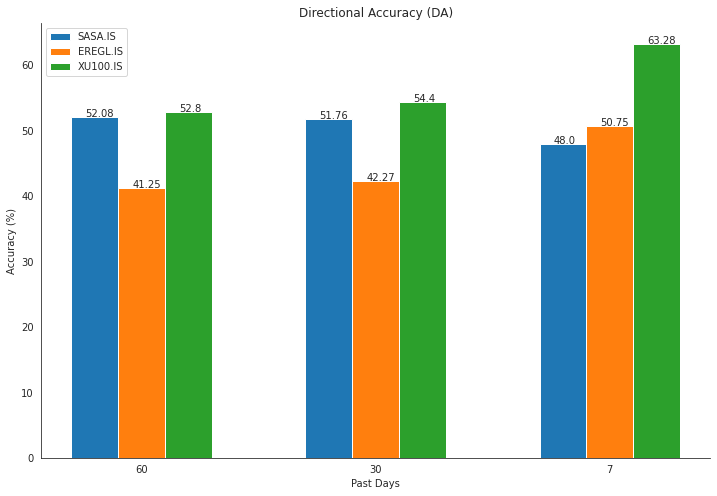

In [8]:
x = np.arange(3)
y1 = [df_res.loc[:4, ['da']].mean()[0] , df_res.loc[5:9, ['da']].mean()[0], df_res.loc[10:14, ['da']].mean()[0]]
y2 = [df_res.loc[15:19, ['da']].mean()[0] , df_res.loc[20:24, ['da']].mean()[0], df_res.loc[25:29, ['da']].mean()[0]]
y3 = [df_res.loc[30:34, ['da']].mean()[0] , df_res.loc[35:39, ['da']].mean()[0], df_res.loc[40:44, ['da']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (12, 8))
bars = plt.bar(x - 0.2, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
bars = plt.bar(x, y2, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
bars = plt.bar(x + 0.2, y3, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Directional Accuracy (DA)')
plt.xlabel('Past Days')
plt.ylabel('Accuracy (%)')
plt.legend(stockCodes)
plt.show()

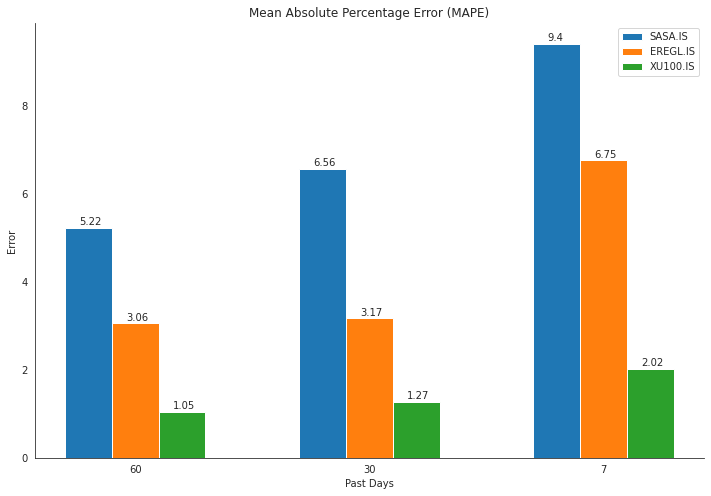

In [9]:
x = np.arange(3)
y1 = [df_res.loc[:4, ['mape']].mean()[0] , df_res.loc[5:9, ['mape']].mean()[0], df_res.loc[10:14, ['mape']].mean()[0]]
y2 = [df_res.loc[15:19, ['mape']].mean()[0] , df_res.loc[20:24, ['mape']].mean()[0], df_res.loc[25:29, ['mape']].mean()[0]]
y3 = [df_res.loc[30:34, ['mape']].mean()[0] , df_res.loc[35:39, ['mape']].mean()[0], df_res.loc[40:44, ['mape']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (12, 8))
bars = plt.bar(x - 0.2, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
bars = plt.bar(x, y2, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
bars = plt.bar(x + 0.2, y3, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Mean Absolute Percentage Error (MAPE)')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()


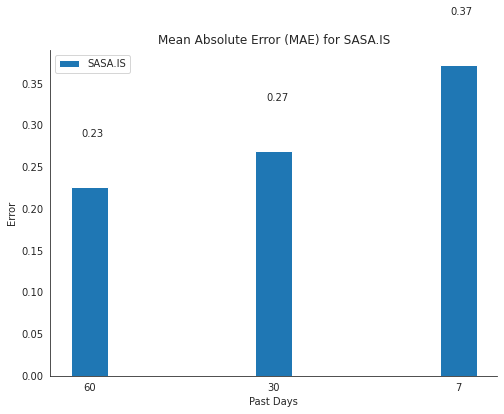

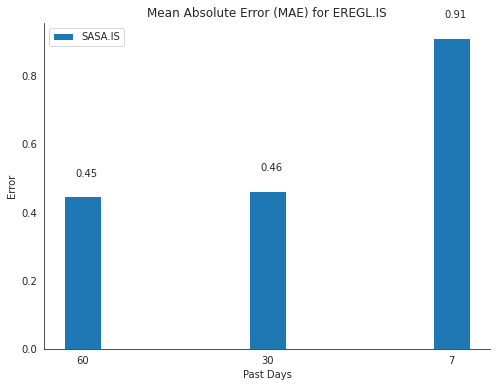

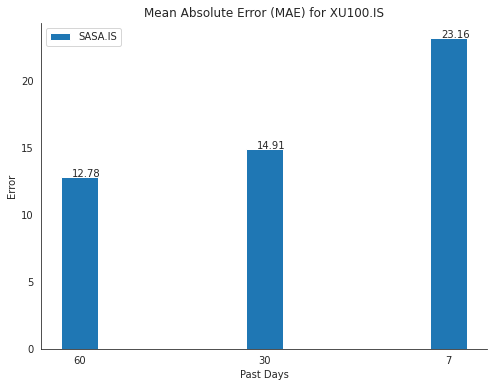

In [10]:
# MAE for SASA.IS
x = np.arange(3)
y1 = [df_res.loc[:4, ['mae']].mean()[0] , df_res.loc[5:9, ['mae']].mean()[0], df_res.loc[10:14, ['mae']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (8, 6))
bars = plt.bar(x, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Mean Absolute Error (MAE) for SASA.IS')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()


# MAE for EREGL.IS
x = np.arange(3)
y1 = [df_res.loc[15:19, ['mae']].mean()[0] , df_res.loc[20:24, ['mae']].mean()[0], df_res.loc[25:29, ['mae']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (8, 6))
bars = plt.bar(x, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Mean Absolute Error (MAE) for EREGL.IS')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()

# MAE for XU100.IS
x = np.arange(3)
y1 = [df_res.loc[30:34, ['mae']].mean()[0] , df_res.loc[35:39, ['mae']].mean()[0], df_res.loc[40:44, ['mae']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (8, 6))
bars = plt.bar(x, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Mean Absolute Error (MAE) for XU100.IS')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()

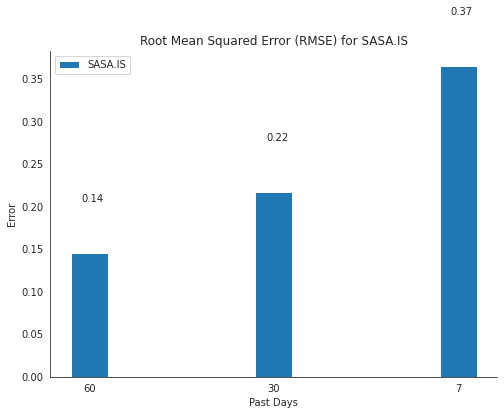

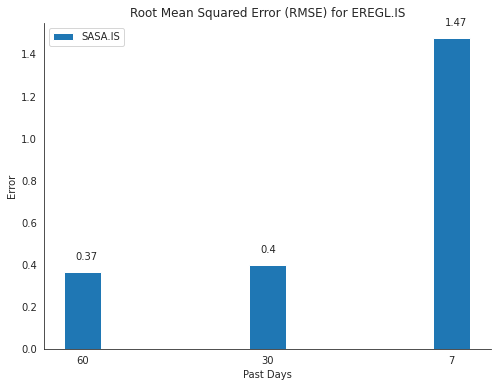

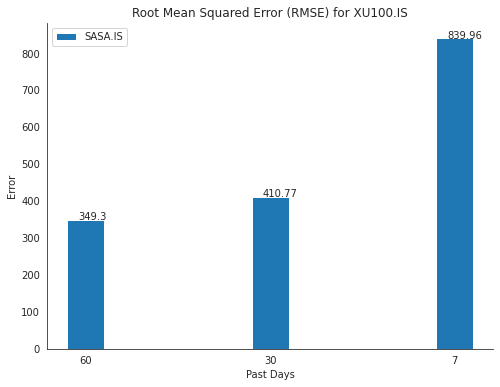

In [11]:
# RMSE for SASA.IS
x = np.arange(3)
y1 = [df_res.loc[:4, ['rmse']].mean()[0] , df_res.loc[5:9, ['rmse']].mean()[0], df_res.loc[10:14, ['rmse']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (8, 6))
bars = plt.bar(x, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Root Mean Squared Error (RMSE) for SASA.IS')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()


# RMSE for EREGL.IS
x = np.arange(3)
y1 = [df_res.loc[15:19, ['rmse']].mean()[0] , df_res.loc[20:24, ['rmse']].mean()[0], df_res.loc[25:29, ['rmse']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (8, 6))
bars = plt.bar(x, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Root Mean Squared Error (RMSE) for EREGL.IS')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()

# RMSE for XU100.IS
x = np.arange(3)
y1 = [df_res.loc[30:34, ['rmse']].mean()[0] , df_res.loc[35:39, ['rmse']].mean()[0], df_res.loc[40:44, ['rmse']].mean()[0]]
width = 0.2
  
# plotting data in grouped manner of bar type
plt.figure(figsize = (8, 6))
bars = plt.bar(x, y1, width)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.06, yval + .06, round(yval, 2))
plt.xticks(x, n_pasts)
plt.title('Root Mean Squared Error (RMSE) for XU100.IS')
plt.xlabel('Past Days')
plt.ylabel('Error')
plt.legend(stockCodes)
plt.show()